In [1]:
%matplotlib notebook
import datetime as dt  # Python standard library datetime  module
import numpy as np
import netCDF4  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

import s2_py as s2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping

import os
import pickle
import wget
import subprocess


import matplotlib.animation as animation

import google.cloud.bigquery
import pandas_gbq
import pandas as pd
import shapefile as shp
import descartes
from shapely.geometry import Polygon, mapping, Point
from sklearn.metrics.pairwise import euclidean_distances

import itertools

In [2]:
# Courtesy Yulia
ca_s2_df = gpd.read_file("/home/scott/w210_Wildfire/DataPrep/Data/Processed/CA_S2Cells/CA_S2Cells.shp")

In [3]:
ca_s2_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_are,FZ_grp,S2_Cells_I,geometry
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,POLYGON ((-116.9852421934208 36.92851788893871...
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,POLYGON ((-117.1735315927328 36.88229296981148...
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,POLYGON ((-117.1735315927328 37.04169221702246...
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,POLYGON ((-118.2994349957241 37.38986432048104...
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,POLYGON ((-118.2994349957241 37.23225420438236...


In [4]:
len(ca_s2_df)

10643

# I left off the date stamps!  But I can go back and get them from the filenames.

In [5]:
data_dir = '/home/scott/sat_aggs/'
csvfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        csvfiles[filename] = (os.path.join(dirpath, filename))

In [6]:
csvfiles.keys()

dict_keys(['20161031_agg.csv', '20160710_agg.csv', '20160920_agg.csv', '20170630_agg.csv', '20170120_agg.csv', '20180220_agg.csv', '20161231_agg.csv', '20160810_agg.csv', '20170510_agg.csv', '20170320_agg.csv', '20160520_agg.csv', 'fapar2016_v2.csv', '20160229_agg.csv', '20170228_agg.csv', '20170831_agg.csv', '20170520_agg.csv', '20170110_agg.csv', '20180210_agg.csv', '20160910_agg.csv', '20171020_agg.csv', '20170930_agg.csv', '20170731_agg.csv', '20170610_agg.csv', '20160420_agg.csv', '20171110_agg.csv', '20160510_agg.csv', '20171010_agg.csv', '20170910_agg.csv', '20160620_agg.csv', '20160110_agg.csv', '20170720_agg.csv', '20160930_agg.csv', '20160731_agg.csv', '20170310_agg.csv', '20170220_agg.csv', '20170410_agg.csv', '20160820_agg.csv', '20160331_agg.csv', '20160410_agg.csv', '20160210_agg.csv', '20160120_agg.csv', '20160831_agg.csv', '20160320_agg.csv', '20170420_agg.csv', '20160430_agg.csv', '20170430_agg.csv', '20161210_agg.csv', '20161120_agg.csv', '20160310_agg.csv', '20180131

In [10]:
year = 2016
dateStart = file.find(str(year))
date = file[dateStart:dateStart+8]
date


'20161031'

In [11]:
#df['date'] = date[0:4] + '-' + date[5:7] + '-' + date[7:]
dateFormatted = date[0:4] + '-' + date[4:6] + '-' + date[6:]
dateFormatted

'2016-10-31'

In [12]:
df['date'] = dateFormatted
df.head()

,Unnamed: 0,mergeKey,lat_min,lat_max,lat_mean,lat_median,lat_std,lat_size,lat_count,lat_nunique,...,faparMask_nunique,faparVal_min,faparVal_max,faparVal_size,faparVal_count,faparVal_nunique,faparVal_myMean,faparVal_myMedian,faparVal_myStd,date
0,0,54c934,41.958333,42.053571,42.018738,42.020833,0.022960,2023,2023,33,...,2,0.092,0.408,2023,2023,263,0.3966615490652252,0.38000003,0.16892046501831295,2016-10-31
1,1,54c9354,41.958333,41.997024,41.978733,41.979167,0.009036,206,206,14,...,2,0.092,0.408,206,206,129,0.3949659045513083,0.39600003,0.2042891002870512,2016-10-31
2,2,54c935c,41.973214,42.011905,41.993210,41.994048,0.009065,206,206,14,...,1,0.064,0.872,206,206,115,0.47986417603724213,0.504,0.16783597956722865,2016-10-31
3,3,54c9364,41.988095,42.026786,42.007709,42.008929,0.009110,205,205,14,...,1,0.096,0.788,205,205,112,0.4146929485041921,0.416,0.15333308356076075,2016-10-31
4,4,54c9414,41.988095,42.029762,42.008885,42.008929,0.009139,206,206,15,...,2,0.100,0.228,206,206,49,0.1521176351416929,0.15200001,0.03254899826668027,2016-10-31


In [17]:
df2 = df.drop(['Unnamed: 0'], axis =1)

In [18]:
df2.head()

,mergeKey,lat_min,lat_max,lat_mean,lat_median,lat_std,lat_size,lat_count,lat_nunique,lon_min,...,faparMask_nunique,faparVal_min,faparVal_max,faparVal_size,faparVal_count,faparVal_nunique,faparVal_myMean,faparVal_myMedian,faparVal_myStd,date
0,54c934,41.958333,42.053571,42.018738,42.020833,0.022960,2023,2023,33,-121.610119,...,2,0.092,0.408,2023,2023,263,0.3966615490652252,0.38000003,0.16892046501831295,2016-10-31
1,54c9354,41.958333,41.997024,41.978733,41.979167,0.009036,206,206,14,-121.526786,...,2,0.092,0.408,206,206,129,0.3949659045513083,0.39600003,0.2042891002870512,2016-10-31
2,54c935c,41.973214,42.011905,41.993210,41.994048,0.009065,206,206,14,-121.479167,...,1,0.064,0.872,206,206,115,0.47986417603724213,0.504,0.16783597956722865,2016-10-31
3,54c9364,41.988095,42.026786,42.007709,42.008929,0.009110,205,205,14,-121.431548,...,1,0.096,0.788,205,205,112,0.4146929485041921,0.416,0.15333308356076075,2016-10-31
4,54c9414,41.988095,42.029762,42.008885,42.008929,0.009139,206,206,15,-121.172619,...,2,0.100,0.228,206,206,49,0.1521176351416929,0.15200001,0.03254899826668027,2016-10-31


In [37]:
df2.dtypes

mergeKey              object
lat_min              float64
lat_max              float64
lat_mean             float64
lat_median           float64
lat_std              float64
lat_size               int64
lat_count              int64
lat_nunique            int64
lon_min              float64
lon_max              float64
lon_mean             float64
lon_median           float64
lon_std              float64
lon_size               int64
lon_count              int64
lon_nunique            int64
faparMask_min           bool
faparMask_max           bool
faparMask_mean       float64
faparMask_median        bool
faparMask_std        float64
faparMask_size         int64
faparMask_count        int64
faparMask_nunique      int64
faparVal_min         float64
faparVal_max         float64
faparVal_size          int64
faparVal_count         int64
faparVal_nunique       int64
faparVal_myMean       object
faparVal_myMedian     object
faparVal_myStd        object
date                  object
dtype: object

In [38]:
df2.replace('--', np.nan, inplace = True)

In [42]:
df2['faparVal_myMean'].isna().sum()

1

In [43]:
df2[df2['faparVal_myMean'].isna()]

,mergeKey,lat_min,lat_max,lat_mean,lat_median,lat_std,lat_size,lat_count,lat_nunique,lon_min,...,faparMask_nunique,faparVal_min,faparVal_max,faparVal_size,faparVal_count,faparVal_nunique,faparVal_myMean,faparVal_myMedian,faparVal_myStd,date
3916,8085fc,37.568452,37.77381,37.671448,37.672619,0.046907,3117,3117,70,-123.077381,...,1,0.0,0.0,3117,3117,1,NaN,NaN,NaN,2016-10-31


In [45]:
(df2['faparVal_myMean']==0).sum()

0

In [46]:
(df2['faparVal_myMedian']==0).sum()

0

In [47]:
df2[df2['faparVal_myMedian'].isna()]

,mergeKey,lat_min,lat_max,lat_mean,lat_median,lat_std,lat_size,lat_count,lat_nunique,lon_min,...,faparMask_nunique,faparVal_min,faparVal_max,faparVal_size,faparVal_count,faparVal_nunique,faparVal_myMean,faparVal_myMedian,faparVal_myStd,date
3916,8085fc,37.568452,37.77381,37.671448,37.672619,0.046907,3117,3117,70,-123.077381,...,1,0.0,0.0,3117,3117,1,NaN,NaN,NaN,2016-10-31


In [48]:
df2['faparVal_myMean'].isna().sum()

1

In [49]:
ca_s2_df[ca_s2_df['S2_Cells_I']=='8085fc']

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_are,FZ_grp,S2_Cells_I,geometry,mergeKey
479,MTR,San Francisco,CA006,ww,0.012579,0.0,low,8085fc,"POLYGON ((-123.0789010480611 37.7189473593804,...",8085fc


In [51]:
# But if I look at the mins, maxes
df2['faparVal_min'].isna().sum()

0

In [52]:
df2['faparVal_max'].isna().sum()

0

In [53]:
#possible, plausible.
(df2['faparVal_min']==0).sum()


645

In [54]:
# not as likely
(df2['faparVal_max']==0).sum()

161

In [58]:
# In cases where there is partial masking the min and max are computed incorrectly.

df2[df2['faparVal_max']==0][['mergeKey', 'faparMask_min', 'faparMask_max', 'faparMask_mean', 
                            'faparMask_median', 'faparMask_std', 'faparMask_size',
       'faparMask_count', 'faparMask_nunique', 'faparVal_min', 'faparVal_max',
       'faparVal_size', 'faparVal_count', 'faparVal_nunique',
       'faparVal_myMean', 'faparVal_myMedian', 'faparVal_myStd', 'date']]

,mergeKey,faparMask_min,faparMask_max,faparMask_mean,faparMask_median,faparMask_std,faparMask_size,faparMask_count,faparMask_nunique,faparVal_min,faparVal_max,faparVal_size,faparVal_count,faparVal_nunique,faparVal_myMean,faparVal_myMedian,faparVal_myStd,date
21,54c94ac,False,True,0.009804,False,0.098771,204,204,2,0.0,0.0,204,204,107,0.3234257662650382,0.296,0.1726033347273246,2016-10-31
465,54cbeb4,False,True,0.203980,False,0.403960,201,201,2,0.0,0.0,201,201,77,0.09542500743991696,0.072000004,0.06868019934882155,2016-10-31
1121,54ce27c,False,True,0.029703,False,0.170188,202,202,2,0.0,0.0,202,202,114,0.4216124797049834,0.416,0.14499857350978282,2016-10-31
1523,54d059,False,True,0.340269,False,0.474090,817,817,2,0.0,0.0,817,817,229,0.3294322965649373,0.316,0.09408824907710782,2016-10-31
1527,54d067,False,True,0.042631,False,0.202147,821,821,2,0.0,0.0,821,821,273,0.3747328414603044,0.356,0.12888641802407427,2016-10-31
1890,54d23b4,False,True,0.282828,False,0.451515,198,198,2,0.0,0.0,198,198,108,0.348253536234859,0.342,0.11884914779407577,2016-10-31
1891,54d23cc,False,True,0.045918,False,0.209844,196,196,2,0.0,0.0,196,196,112,0.3794652642731998,0.34800002,0.13783712824887703,2016-10-31
2442,54d4e3,False,True,0.384615,False,0.486827,754,754,2,0.0,0.0,754,754,191,0.43053450634510354,0.43600002,0.038391683418086194,2016-10-31
2455,54d52c,False,True,0.747134,True,0.434728,2966,2966,2,0.0,0.0,2966,2966,415,0.45128535491228106,0.432,0.10682163133225607,2016-10-31
2457,80802c,False,True,0.645390,True,0.478476,2961,2961,2,0.0,0.0,2961,2961,384,0.43911240159046083,0.432,0.07665555178051896,2016-10-31


####  Problem noted, save the files to disk then fix the mins and maxes in the bigquery push notebook. 

In [65]:
ca_s2_df['mergeKey'] = ca_s2_df['S2_Cells_I']
df3 = ca_s2_df.merge(df2, on = 'mergeKey')
len(df3)

10643

<IPython.core.display.Javascript object>


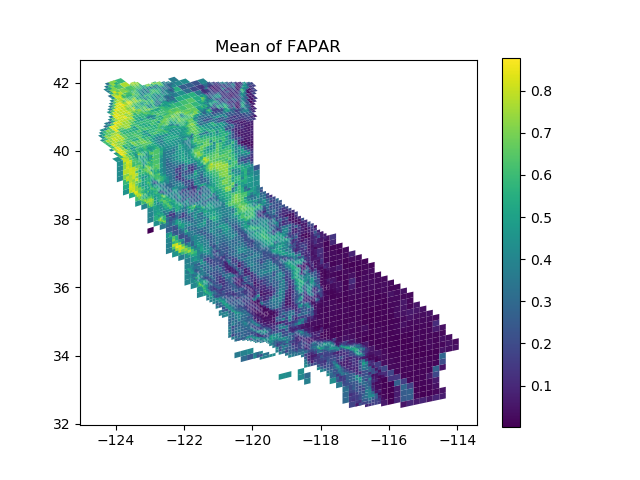

Text(0.5, 1.0, 'Mean of FAPAR')

In [67]:
df3['faparVal_myMean'] = df3['faparVal_myMean'].astype('float64')
df3.plot(column = 'faparVal_myMean', legend = True)#, label = 'Mean FAPAR', legend = True)
plt.title('Mean of FAPAR')

In [69]:
# Do it for 2016 only
year = 2016
dates = []


data_dir = '/home/scott/sat_aggs/'
csvfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        csvfiles[filename] = (os.path.join(dirpath, filename))

for filename, fullpath in csvfiles.items():
    dateStart = filename.find(str(year))
    if dateStart!= -1: #file includes date of interest
        date = filename[dateStart:dateStart+8]  # 20161031 for example
        dateFormatted = date[0:4] + '-' + date[4:6] + '-' + date[6:]   #2016-10-31 for example
        dates.append(date)
        with open(fullpath, 'rb') as f:
            df = pd.read_csv(f)
        df['date'] = dateFormatted
        df.to_csv(data_dir + 'dated/' + filename[0:-4] + '_date' + filename[-4:])  #/home/scott/sat_aggs/20161031_agg_date.csv for example


sorted(dates)

/home/scott/anaconda3/envs/sat/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/scott/anaconda3/envs/sat/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['2016.csv',
 '20160110',
 '20160120',
 '20160131',
 '20160210',
 '20160220',
 '20160229',
 '20160310',
 '20160320',
 '20160331',
 '20160410',
 '20160420',
 '20160430',
 '20160510',
 '20160520',
 '20160531',
 '20160610',
 '20160620',
 '20160630',
 '20160710',
 '20160720',
 '20160731',
 '20160810',
 '20160820',
 '20160831',
 '20160910',
 '20160920',
 '20160930',
 '20161010',
 '20161020',
 '20161031',
 '20161031',
 '20161110',
 '20161120',
 '20161130',
 '20161210',
 '20161220',
 '20161231',
 '2016_v2.']

In [77]:
dates = []
data_dir = '/home/scott/sat_aggs/'
csvfiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        csvfiles[filename] = (os.path.join(dirpath, filename))

for year in range(2017, 2019):
    #year = 2016

    for filename, fullpath in csvfiles.items():
        dateStart = filename.find(str(year))
        if dateStart!= -1: #file includes date of interest
            date = filename[dateStart:dateStart+8]  # 20161031 for example
            dateFormatted = date[0:4] + '-' + date[4:6] + '-' + date[6:]   #2016-10-31 for example
            dates.append(date)
            with open(fullpath, 'rb') as f:
                df = pd.read_csv(f)
            df['date'] = dateFormatted
            df2 = df.drop(['latIdx_min',
                   'latIdx_max',
                   'latIdx_myMean',
                   'latIdx_myMedian',
                   'latIdx_myStd',
                   'latIdx_size',
                   'latIdx_count',
                   'latIdx_nunique',
                   'lonIdx_min',
                   'lonIdx_max',
                   'lonIdx_myMean',
                   'lonIdx_myMedian',
                   'lonIdx_myStd',
                   'lonIdx_size',
                   'lonIdx_count',
                   'lonIdx_nunique'],
                  axis = 1)
            df2.to_csv(data_dir + 'dated/' + filename[0:-4] + '_date' + filename[-4:])  #/home/scott/sat_aggs/20161031_agg_date.csv for example


sorted(dates)

['20170110',
 '20170120',
 '20170131',
 '20170210',
 '20170220',
 '20170228',
 '20170310',
 '20170320',
 '20170331',
 '20170410',
 '20170420',
 '20170430',
 '20170510',
 '20170520',
 '20170531',
 '20170610',
 '20170620',
 '20170630',
 '20170710',
 '20170720',
 '20170731',
 '20170810',
 '20170820',
 '20170831',
 '20170910',
 '20170920',
 '20170930',
 '20171010',
 '20171020',
 '20171031',
 '20171110',
 '20171120',
 '20171130',
 '20171210',
 '20171220',
 '20171231',
 '20180110',
 '20180120',
 '20180131',
 '20180210',
 '20180220',
 '20180228',
 '20180310',
 '20180320',
 '20180331',
 '20180410',
 '20180420',
 '20180430',
 '20180510',
 '20180520',
 '20180531',
 '20180610',
 '20180620',
 '20180630',
 '20180710',
 '20180720',
 '20180731',
 '20180810',
 '20180820',
 '20180831',
 '20180910',
 '20180920',
 '20180930',
 '20181010',
 '20181020',
 '20181031',
 '20181110',
 '20181120',
 '20181130',
 '20181210',
 '20181220',
 '20181231']